In [1]:
from utils.utils import read_config, get_collection, cross_validation
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC 
from models.Models import LogisticRegressor
from utils_parameter_search.dataset_params import datasets
from cleaning_data.DataPipeline import PipelineCV


In [2]:
config = read_config()
collection = get_collection(config)

In [3]:
models = collection.aggregate([{"$sort": {"model": 1, "accuracy": -1}},{"$group": {"_id": "$model", "model_type": {"$first": "$model_type"}, "accuracy": {"$first": "$accuracy"}, "dataset": {"$first":"$dataset"}, "params_of_fit": {"$first": "$params_of_fit"}, "params_initialization": {"$first": "$params_initialization"} }}, {"$sort": {"accuracy": 1}}])
models = list(models)

In [62]:
import pandas as pd


models_df = pd.DataFrame(models).rename(columns = {"_id": "model"})
models_df

,model,model_type,accuracy,dataset,params_of_fit,params_initialization
0,poly_svm,svm,0.705937,complete,None,"{'kernel': 'poly', 'C': 0.031437328537707775, ..."
1,tree,trees,0.714591,trees_cleaned_special,None,"{'criterion': 'gini', 'splitter': 'random', 'm..."
2,deep_neighbor_compressed_nn,neural_networks,0.726898,complete,"{'epochs': 590, 'batch_size': 128, 'device': '...","{'n_neighbors': 20, 'compression_size': 115, '..."
3,gradient_boosting,trees,0.729304,trees,None,"{'loss': 'log_loss', 'n_estimators': 52, 'min_..."
4,naive_bayes,bayes,0.730491,naive_bayes,"{'alpha': 6, 'anderson_statistic_threshold': 1...",None
5,knn,knn,0.730750,complete_one_hot,"{'k': 100, 'p': 1}",None
6,lda,bayes,0.731228,complete,None,None
7,neighbor_nn,neural_networks,0.731476,complete_one_hot,"{'epochs': 453, 'batch_size': 128, 'device': '...","{'n_neighbors': 2, 'hidden': 7, 'activation_fu..."
8,qda,bayes,0.732199,complete,None,None
9,ada_boost,trees,0.733142,trees_cleaned_special,None,"{'n_estimators': 150, 'learning_rate': 0.39687..."


Text(0.5, 1.0, 'Model performances')

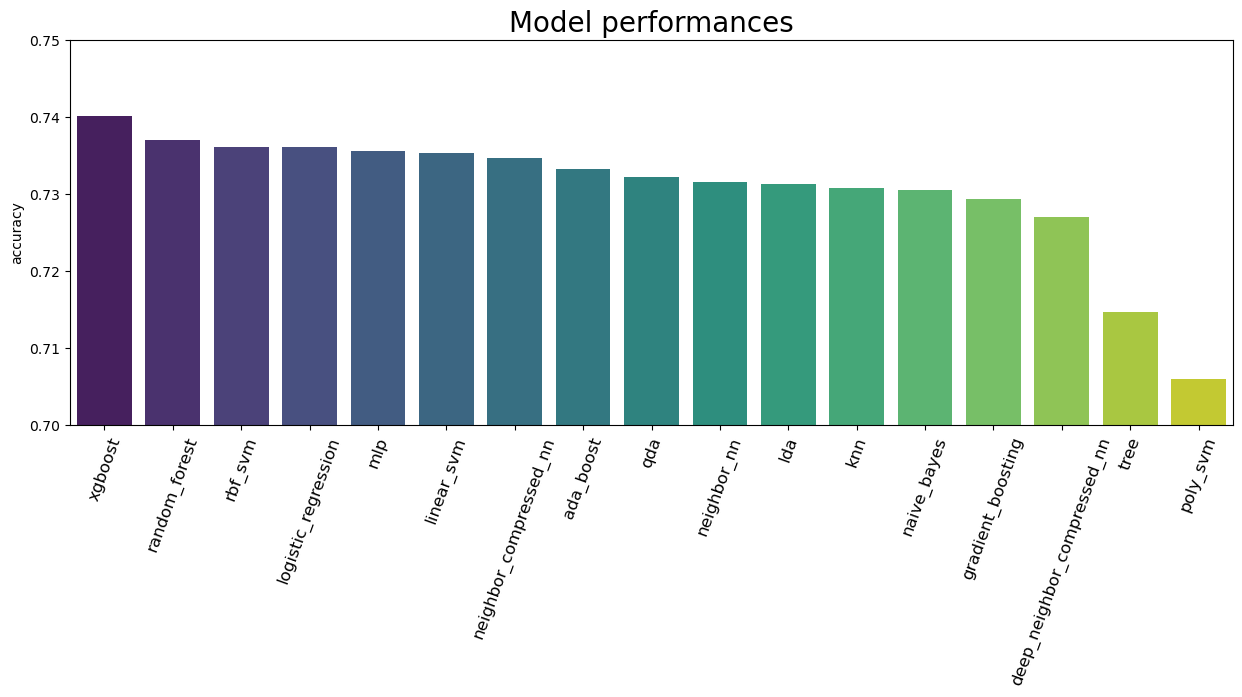

In [63]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize = (15, 5))
sns.barplot(models_df[::-1], x = "model", y = "accuracy", palette = "viridis")
plt.xticks(rotation=70)
plt.ylim(0.70, 0.75)
plt.xlabel("")
plt.xticks(size = 12)
plt.title("Model performances", fontdict={"size": 20})

In [61]:
all_models = list(collection.find({}))
all_models = pd.DataFrame(all_models).drop(columns = ["_id"])
all_models.head()

,model,model_type,accuracy,std,params_of_fit,dataset,time,params_initialization
0,logistic_regression,regression,0.722805,0.007045,"{'penalty': 'elasticnet', 'C': 25943.086804474...",complete,2024-04-18 23:22:47.617,NaN
1,logistic_regression,regression,0.730756,0.006480,"{'penalty': None, 'learning_rate': 0.002556556...",complete_one_hot,2024-04-18 23:23:19.807,NaN
2,logistic_regression,regression,0.730033,0.006157,"{'penalty': None, 'learning_rate': 0.008681500...",complete_one_hot,2024-04-18 23:23:49.497,NaN
3,logistic_regression,regression,0.730033,0.006157,"{'penalty': None, 'learning_rate': 0.004315031...",complete_one_hot,2024-04-18 23:24:20.640,NaN
4,logistic_regression,regression,0.726416,0.006588,"{'penalty': 'lasso', 'C': 18809.38799271452, '...",complete,2024-04-18 23:24:51.928,NaN


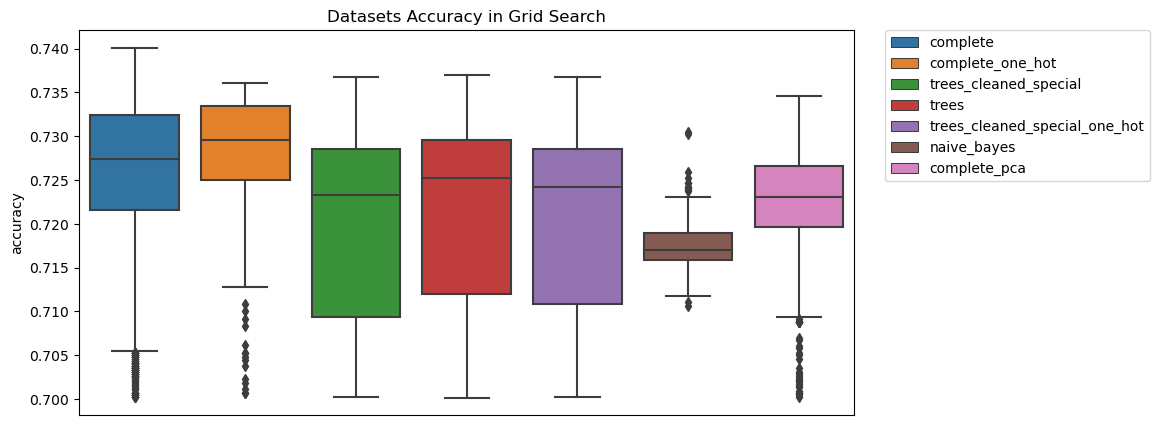

In [62]:

plt.figure(figsize = (10, 5))
all_models = all_models[(all_models["accuracy"] > 0.70)]
g = sns.boxplot(all_models, y = "accuracy", x ="dataset", orient = "v", hue = "dataset", dodge = False)
plt.xticks(rotation=60)
plt.title("Datasets Accuracy in Grid Search")
# plt.tight_layout()
# plt.grid()
plt.setp(g.axes, xticks=[], xlabel='')
plt.legend(bbox_to_anchor = (1.04,1), borderaxespad=0)
plt.show()


c:\Users\jurko\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 10000x500 with 0 Axes>

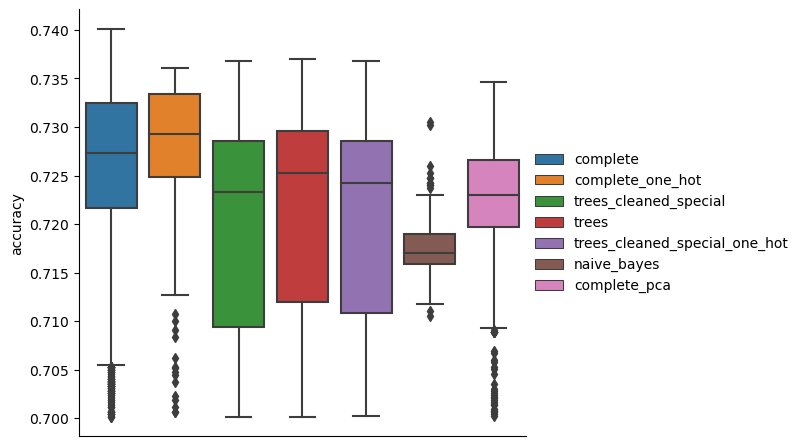

In [8]:
plt.figure(figsize = (100, 5))
g = sns.catplot(all_models, kind = "box", y = "accuracy", x ="dataset", hue = "dataset", orient = "v", legend_out=True,dodge=False)
g.add_legend()
plt.setp(g.axes, xticks=[], xlabel='')
g.figure.subplots_adjust(left=0.06)
plt.show()

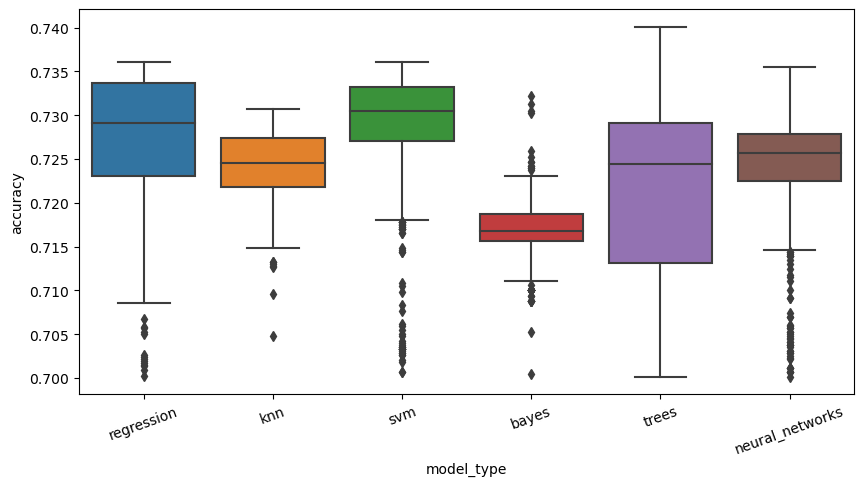

In [63]:
plt.figure(figsize = (10, 5))
plt.tight_layout()
all_models = all_models[all_models["accuracy"] > 0.70]
sns.boxplot(all_models, x = "model_type", y ="accuracy")
plt.xticks(rotation=20)
plt.show()

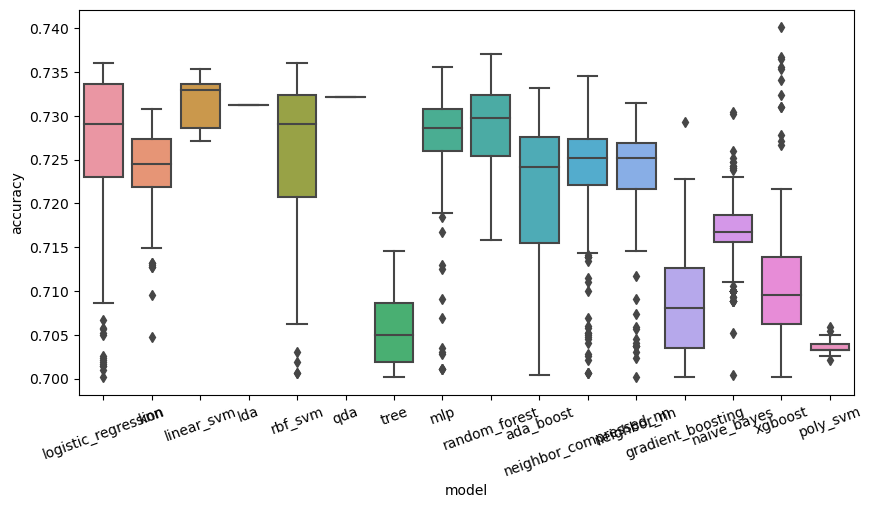

In [64]:
plt.figure(figsize = (10, 5))
plt.tight_layout()
all_models = all_models[all_models["accuracy"] > 0.70]
sns.boxplot(all_models, x = "model", y ="accuracy")
plt.xticks(rotation=20)
plt.show()

In [65]:
models

[{'_id': 'deep_neighbor_compressed_nn',
  'model_type': 'neural_networks',
  'accuracy': 0.5801671293249007,
  'dataset': 'complete',
  'params_of_fit': {'epochs': 129,
   'batch_size': -1,
   'device': 'cuda',
   'lr': 0.0023942443847798215,
   'l2_lambda': 0.19562951472367615},
  'params_initialization': {'n_neighbors': 2,
   'compression_size': 62,
   'neighbor_size': 13,
   'hidden': 5,
   'activation_function': 'tanh',
   'n_layers': 1}},
 {'_id': 'poly_svm',
  'model_type': 'svm',
  'accuracy': 0.7059370975588817,
  'dataset': 'complete',
  'params_of_fit': None,
  'params_initialization': {'kernel': 'poly',
   'C': 0.031437328537707775,
   'cache_size': 7000}},
 {'_id': 'tree',
  'model_type': 'trees',
  'accuracy': 0.7145911913688006,
  'dataset': 'trees_cleaned_special',
  'params_of_fit': None,
  'params_initialization': {'criterion': 'gini',
   'splitter': 'random',
   'max_depth': 443,
   'min_samples_split': 193}},
 {'_id': 'gradient_boosting',
  'model_type': 'trees',
  '

In [ ]:
from cleaning_data.DataPipeline import PipelineCV
from utils_parameter_search.dataset_params import datasets
from utils_parameter_search.models_params import models
from utils.utils import cross_validation, load
import pickle

target_y = config["DATA"]["target_y"]
sep_processed_data = config["DATA"]["sep_processed_data"]
# if sep_processed_data == "\\t":
#     sep_processed_data == "\t"

sep_processed_data = "\t"
data_dir: str = "data/split_data"

X, y, _, _ = load(
        data_dir, target_y, sep_processed_data=sep_processed_data, return_df=True
    )

new = []
for _, row in models_df.iterrows():
    dataset = datasets[row["dataset"]]
    model = models[row["model"]]["model"]
    device = models[row["model"]].get("device", "cpu")
    pipeline = PipelineCV("RiskPerformance", **dataset)
    accuracy, std, complete_metrics = cross_validation(model, X, y, pipeline, 10, params_initialization=row["params_initialization"], params_of_fit = row["params_of_fit"], perform_extensive_analysis=True, device = device)
    # print(row["params_initialization"])
    # models_df.loc[models_df["model"] == model, "new_accuracy"] = accuracy
    # models_df.loc[models_df["model"] == model,"std"] = std
    # models_df.loc[models_df["model"] == model, "complete_metrics"] = complete_metrics
    new.append({"model":row["model"], "new_accuracy" : accuracy,"std" : std,"complete_metrics" : complete_metrics})
with open("results.obj", "wb") as fh:
    pickle.dump(new, fh)

In [6]:
import pickle
import pandas as pd
with open("results.obj", "rb") as fh:
    new = pickle.load(fh)

new_df = pd.DataFrame(new)
new_df
new_models_df = pd.merge(models_df, new_df)

In [7]:
new_models_df

,model,model_type,accuracy,dataset,params_of_fit,params_initialization,new_accuracy,std,complete_metrics
0,poly_svm,svm,0.705937,complete,None,"{'kernel': 'poly', 'C': 0.031437328537707775, ...",0.705937,0.007702,"{'Confusion Matrix': [[123, 81, 29, 182], [117..."
1,tree,trees,0.714591,trees_cleaned_special,None,"{'criterion': 'gini', 'splitter': 'random', 'm...",0.711734,0.005594,"{'Confusion Matrix': [[154, 50, 64, 147], [155..."
2,gradient_boosting,trees,0.729304,trees,None,"{'loss': 'log_loss', 'n_estimators': 52, 'min_...",0.728560,0.007602,"{'Confusion Matrix': [[145, 59, 41, 170], [146..."
3,naive_bayes,bayes,0.730491,naive_bayes,"{'alpha': 6, 'anderson_statistic_threshold': 1...",None,0.730491,0.006961,"{'Confusion Matrix': [[146, 58, 44, 167], [149..."
4,knn,knn,0.730750,complete_one_hot,"{'k': 100, 'p': 1}",None,0.730750,0.008339,"{'Confusion Matrix': [[155, 49, 43, 168], [149..."
5,lda,bayes,0.731228,complete,None,None,0.731228,0.007291,"{'Confusion Matrix': [[153, 51, 49, 162], [157..."
6,neighbor_nn,neural_networks,0.731476,complete_one_hot,"{'epochs': 453, 'batch_size': 128, 'device': '...","{'n_neighbors': 2, 'hidden': 7, 'activation_fu...",0.732440,0.006929,"{'Confusion Matrix': [[149, 55, 42, 169], [151..."
7,qda,bayes,0.732199,complete,None,None,0.732199,0.008070,"{'Confusion Matrix': [[154, 50, 49, 162], [159..."
8,ada_boost,trees,0.733142,trees_cleaned_special,None,"{'n_estimators': 150, 'learning_rate': 0.39687...",0.733142,0.008256,"{'Confusion Matrix': [[155, 49, 47, 164], [154..."
9,neighbor_compressed_nn,neural_networks,0.734605,complete,"{'epochs': 297, 'batch_size': 256, 'device': '...","{'n_neighbors': 105, 'compression_size': 25, '...",0.733624,0.006070,"{'Confusion Matrix': [[148, 56, 43, 168], [152..."


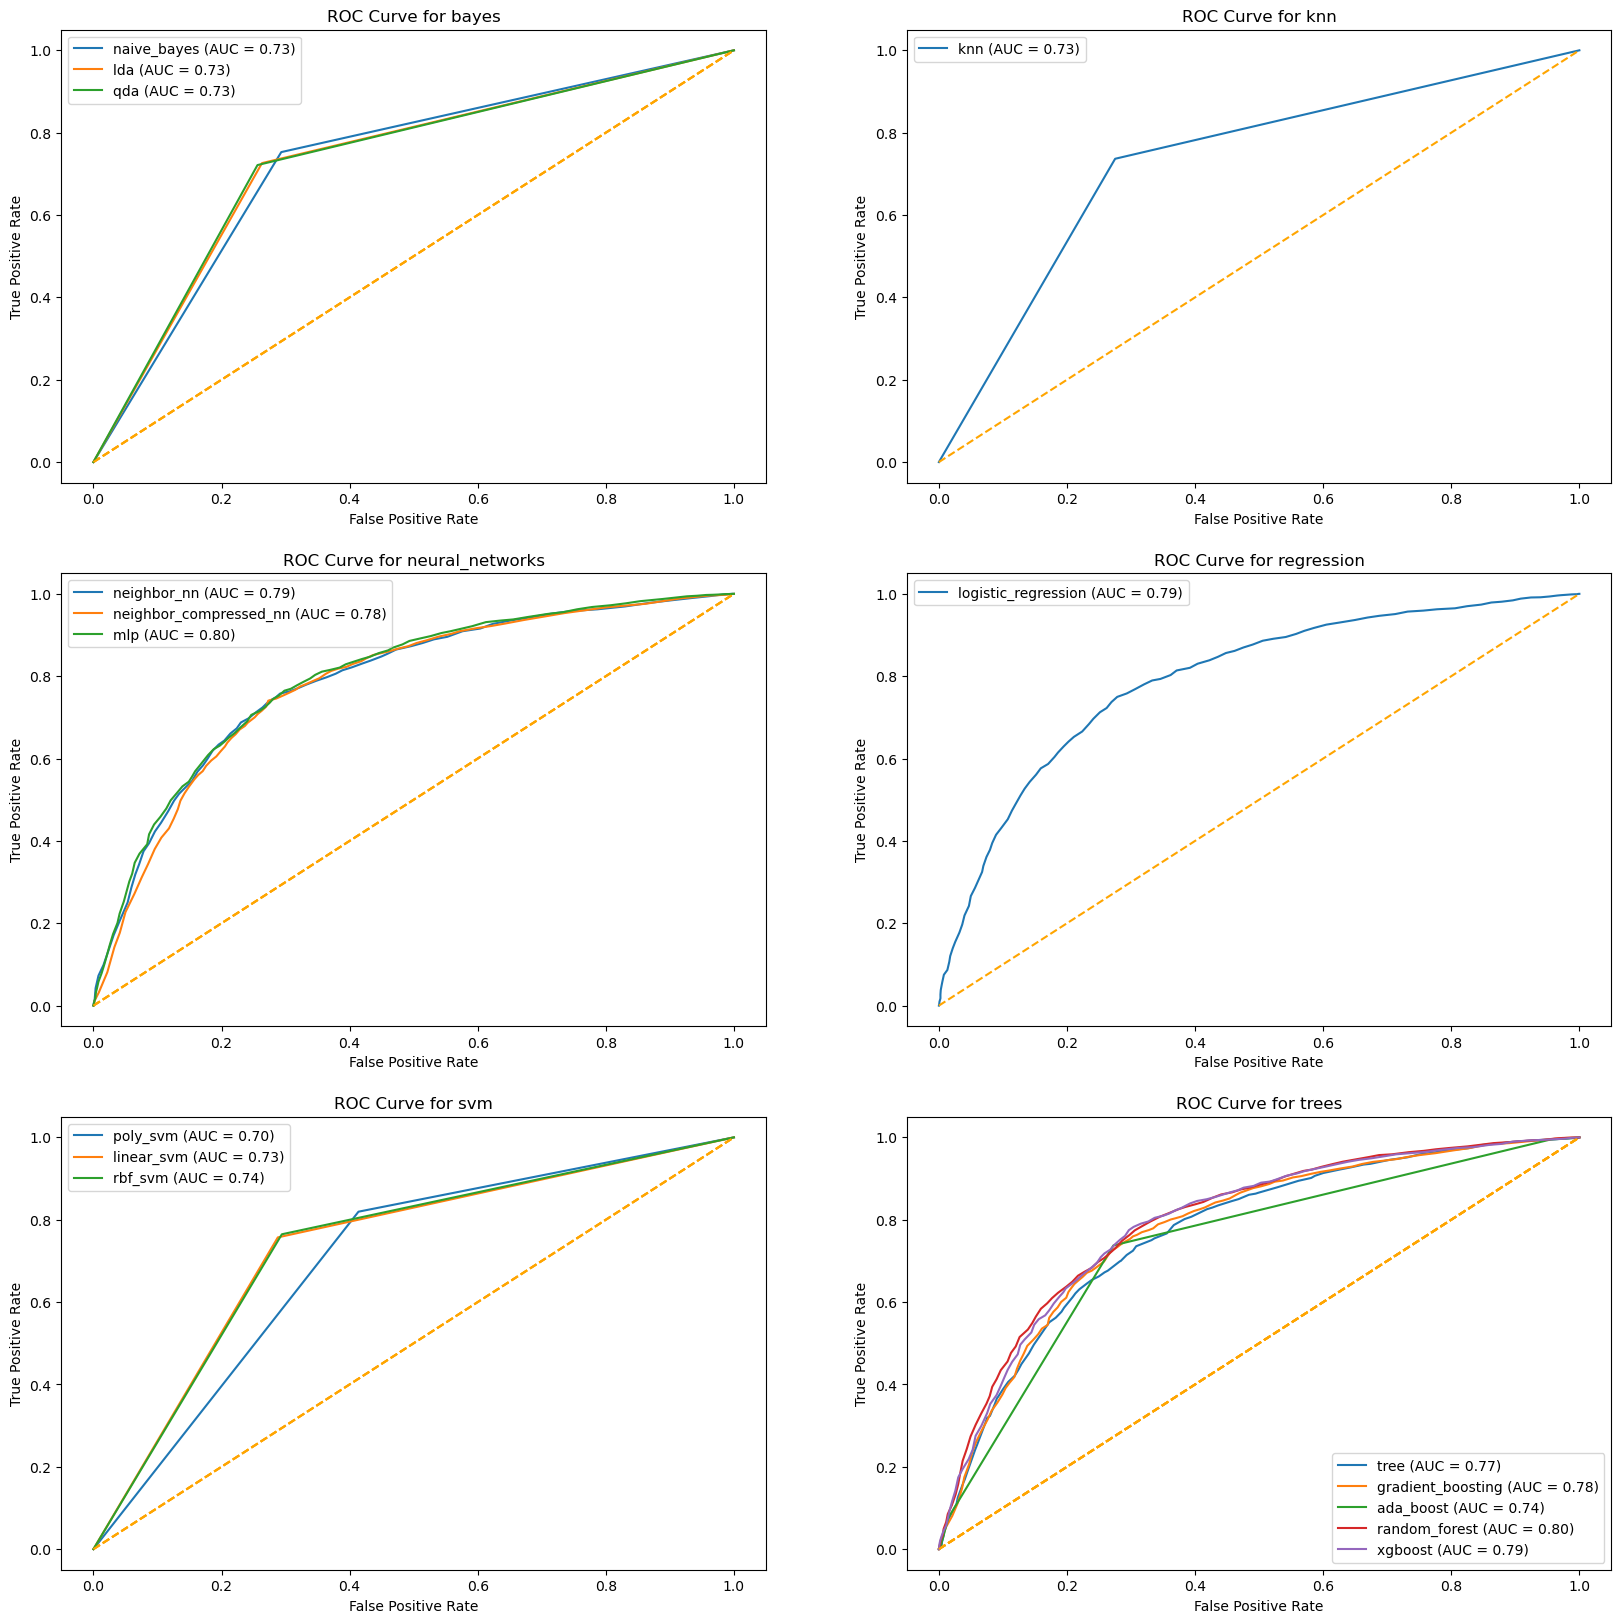

In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt
from utils.utils import plot_roc

def plot_roc_curves(model_df):
    grouped = model_df.groupby("model_type")
    n = len(grouped)
    fig, axes= plt.subplots(math.ceil(n/2),2,figsize=(20,20))
    axes = axes.reshape((-1))
    for (model_group, model_metrics_df), ax in zip(grouped, axes):
        for _, model_row in model_metrics_df.iterrows():
            model_name = model_row["model"]
            metrics= model_row["complete_metrics"]
            # model_name = model_dict["model"]
            roc = metrics["roc"]
            tpr = np.mean(roc["tpr"], axis = 0)
            fpr = np.mean(roc["fpr"], axis = 0)
            
            # plot_roc(fpr, tpr, model_name)
            ax.plot(
                fpr,
                tpr,
                # marker="-",
                label=f"{model_name} (AUC = {abs(np.trapz(x = fpr, y = tpr)):.02f})",
            )
            ax.plot([0, 1], [0, 1], linestyle="--", color="orange")
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.legend()
            ax.set_title(f"ROC Curve for {model_group}")

plot_roc_curves(new_models_df)

In [9]:
models_df.sort_values("accuracy", ascending = True).iloc[:4]

,model,model_type,accuracy,dataset,params_of_fit,params_initialization
0,poly_svm,svm,0.705937,complete,None,"{'kernel': 'poly', 'C': 0.031437328537707775, ..."
1,tree,trees,0.714591,trees_cleaned_special,None,"{'criterion': 'gini', 'splitter': 'random', 'm..."
2,deep_neighbor_compressed_nn,neural_networks,0.726898,complete,"{'epochs': 590, 'batch_size': 128, 'device': '...","{'n_neighbors': 20, 'compression_size': 115, '..."
3,gradient_boosting,trees,0.729304,trees,None,"{'loss': 'log_loss', 'n_estimators': 52, 'min_..."


# Training model Ensemble

In [84]:

from models.NN_Models import MLP, NeighborCompressedNN, NeighborNN



In [11]:
class ModelEnsemble:
    def __init__(self, models_df, top_n = 2):
        self.models = []
        for _, model_row in models_df.sort_values("accuracy", ascending = False).iloc[:top_n].iterrows():
            model_name = model_row["model"]
            self.models.append({"model_name": model_name, "model_class":models_classes[model_name], "params_initialization": model_row["params_initialization"], "params_of_fit": model_row["params_of_fit"], "pipeline": PipelineCV("RiskPerformance", **datasets[model_row["dataset"]])})
            init = model_row["params_initialization"]
            if init is not None:
                self.models[-1]["model"] = models_classes[model_name](**init)
            else:
                self.models[-1]["model"] = models_classes[model_name]()


    def fit(self, X, y) -> None:
        for model in self.models:
            X_transformed, y_transformed = model["pipeline"].fit_transform(X, y)
            if model["params_of_fit"] is not None:
                model["model"].fit(X_transformed, y_transformed,**model["params_of_fit"] )
            else:
                model["model"].fit(X_transformed, y_transformed)

    def predict(self, X):
        predictions = []
        for model in self.models:
            X_transformed = model["pipeline"].transform(X)
            predictions.append(model["model"].predict(X_transformed))
        predictions_ratio = np.mean(predictions, axis=0)

        return np.where(predictions_ratio>=0.5, 1,0)
        

    def predict_proba(self, X):
        predictions = []
        for model in self.models:
            X_transformed = model["pipeline"].transform(X)
            try:
                ps = model["model"].predict_proba(X_transformed)
                if np.ndim(ps) >1:
                    ps = ps[:,1]
                predictions.append(ps)
            except:
                predictions.append(model["model"].predict(X_transformed))
        predictions_ratio = np.mean(predictions, axis=0)

        return np.where(predictions_ratio>=0.5, 1,0)

In [124]:
models_classes = {"model_ensemble": ModelEnsemble, "mlp": MLP, "neighbor_nn": NeighborNN, "compressed_neighbor_nn": NeighborCompressedNN,"linear_svm": SVC,"poly_svm": SVC, "rbf_svm": SVC, "random_forest": RandomForestClassifier, "xgboost": XGBClassifier, "logistic_regression": LogisticRegressor}


In [ ]:
from utils.utils import load

X, y, _, _ = load("data/split_data", "RiskPerformance", return_df = True)
model_ensemble = ModelEnsemble(new_models_df)

In [81]:
new_models_df

,model,accuracy,model_type,dataset,params_of_fit,params_initialization,new_accuracy,std,complete_metrics,F1,Accuracy,Precision,Recall,Specificity,F1_std,Accuracy_std,Precision_std,Recall_std,Specificity_std
0,model_ensemble,0.739176,model_ensemble,trees,None,None,0.736047,0.023843,"{'Confusion Matrix': [[145, 59, 37, 174], [152...",0.7489,0.7360,0.7342,0.7646,0.7058,0.0079,0.0075,0.0096,0.0079,0.0090
0,poly_svm,0.705937,svm,complete,None,"{'kernel': 'poly', 'C': 0.031437328537707775, ...",0.705937,0.007702,"{'Confusion Matrix': [[123, 81, 29, 182], [117...",0.7417,0.7059,0.6781,0.8195,0.5862,0.0073,0.0077,0.0104,0.0071,0.0112
1,tree,0.714591,trees,trees_cleaned_special,None,"{'criterion': 'gini', 'splitter': 'random', 'm...",0.711734,0.005594,"{'Confusion Matrix': [[154, 50, 64, 147], [155...",0.7190,0.7117,0.7228,0.7177,0.7049,0.0073,0.0056,0.0103,0.0135,0.0164
2,gradient_boosting,0.729304,trees,trees,None,"{'loss': 'log_loss', 'n_estimators': 52, 'min_...",0.728560,0.007602,"{'Confusion Matrix': [[145, 59, 41, 170], [146...",0.7406,0.7286,0.7282,0.7539,0.7011,0.0091,0.0076,0.0093,0.0107,0.0086
3,naive_bayes,0.730491,bayes,naive_bayes,"{'alpha': 6, 'anderson_statistic_threshold': 1...",None,0.730491,0.006961,"{'Confusion Matrix': [[146, 58, 44, 167], [149...",0.7420,0.7305,0.7319,0.7528,0.7067,0.0076,0.0070,0.0095,0.0066,0.0090
4,knn,0.730750,knn,complete_one_hot,"{'k': 100, 'p': 1}",None,0.730750,0.008339,"{'Confusion Matrix': [[155, 49, 43, 168], [149...",0.7380,0.7307,0.7398,0.7366,0.7248,0.0090,0.0083,0.0108,0.0082,0.0094
5,lda,0.731228,bayes,complete,None,None,0.731228,0.007291,"{'Confusion Matrix': [[153, 51, 49, 162], [157...",0.7357,0.7312,0.7460,0.7261,0.7369,0.0074,0.0073,0.0092,0.0072,0.0091
6,neighbor_nn,0.731476,neural_networks,complete_one_hot,"{'epochs': 453, 'batch_size': 128, 'device': '...","{'n_neighbors': 2, 'hidden': 7, 'activation_fu...",0.732440,0.006929,"{'Confusion Matrix': [[149, 55, 42, 169], [151...",0.7424,0.7324,0.7365,0.7489,0.7151,0.0074,0.0069,0.0087,0.0081,0.0081
7,qda,0.732199,bayes,complete,None,None,0.732199,0.008070,"{'Confusion Matrix': [[154, 50, 49, 162], [159...",0.7351,0.7322,0.7498,0.7213,0.7439,0.0085,0.0081,0.0101,0.0086,0.0098
8,ada_boost,0.733142,trees,trees_cleaned_special,None,"{'n_estimators': 150, 'learning_rate': 0.39687...",0.733142,0.008256,"{'Confusion Matrix': [[155, 49, 47, 164], [154...",0.7399,0.7331,0.7427,0.7375,0.7275,0.0091,0.0083,0.0100,0.0099,0.0113


In [87]:

accuracies = []
stds = []
top_ns = range(2, 6)
complete_metrics_list = []
for top_n in top_ns:
    pipeline = PipelineCV("RiskPerformance", **datasets["trees"])
    try:
        acc, std, complete_metrics = cross_validation(ModelEnsemble, X, y, pipeline, 10, params_initialization={"models_df":new_models_df[new_models_df["model"] != "model_ensemble"], "top_n":top_n}, model_requires_df=True, perform_extensive_analysis=True)
        accuracies.append(acc)
        stds.append(std)
        complete_metrics_list.append(complete_metrics)
    except:
        accuracies.append(None)
        stds.append(None)
        complete_metrics_list.append(None)
    

In [89]:
accuracies

[0.7389216724379704, 0.7379646853447043, 0.7377340239819133, None]

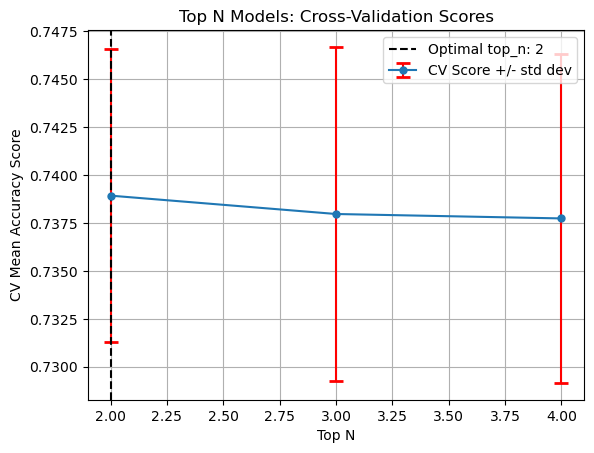

In [92]:
optimum_top_n = list(top_ns)[np.argmax(accuracies[:3])]
plt.errorbar(top_ns[:3], accuracies[:3], yerr=stds[:3], fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimum_top_n, linestyle='--', color='k', label=f'Optimal top_n: {optimum_top_n}')

plt.title('Top N Models: Cross-Validation Scores')
plt.xlabel('Top N')
plt.ylabel('CV Mean Accuracy Score')
plt.legend()
# plt.xscale('log')
plt.grid(True)
plt.show()

In [102]:
best_metrics = complete_metrics_list[np.argmax(accuracies[:3])]
# best_metrics

In [94]:
# new_models_df.columns

In [95]:
# best_metrics

In [103]:
np.max(accuracies[:3])

0.7389216724379704

In [104]:
ensemble_df = pd.DataFrame([{"model":"model_ensemble", "accuracy":np.max(accuracies[:3]),"model_type":"model_ensemble","dataset":"trees", "params_of_fit":None, "params_initialization":None, "new_accuracy": np.mean(best_metrics["Accuracy"]), "std":np.std(best_metrics["Accuracy"]), "complete_metrics": best_metrics}])
# ensemble_df["complete_metrics"] = best_metrics
ensemble_df

,model,accuracy,model_type,dataset,params_of_fit,params_initialization,new_accuracy,std,complete_metrics
0,model_ensemble,0.738922,model_ensemble,trees,None,None,0.737001,0.025966,"{'Confusion Matrix': [[145, 59, 41, 170], [148..."


In [105]:
new_models_df = pd.concat((ensemble_df, new_models_df))


In [113]:
new_models_df = new_models_df.dropna(subset = "F1")

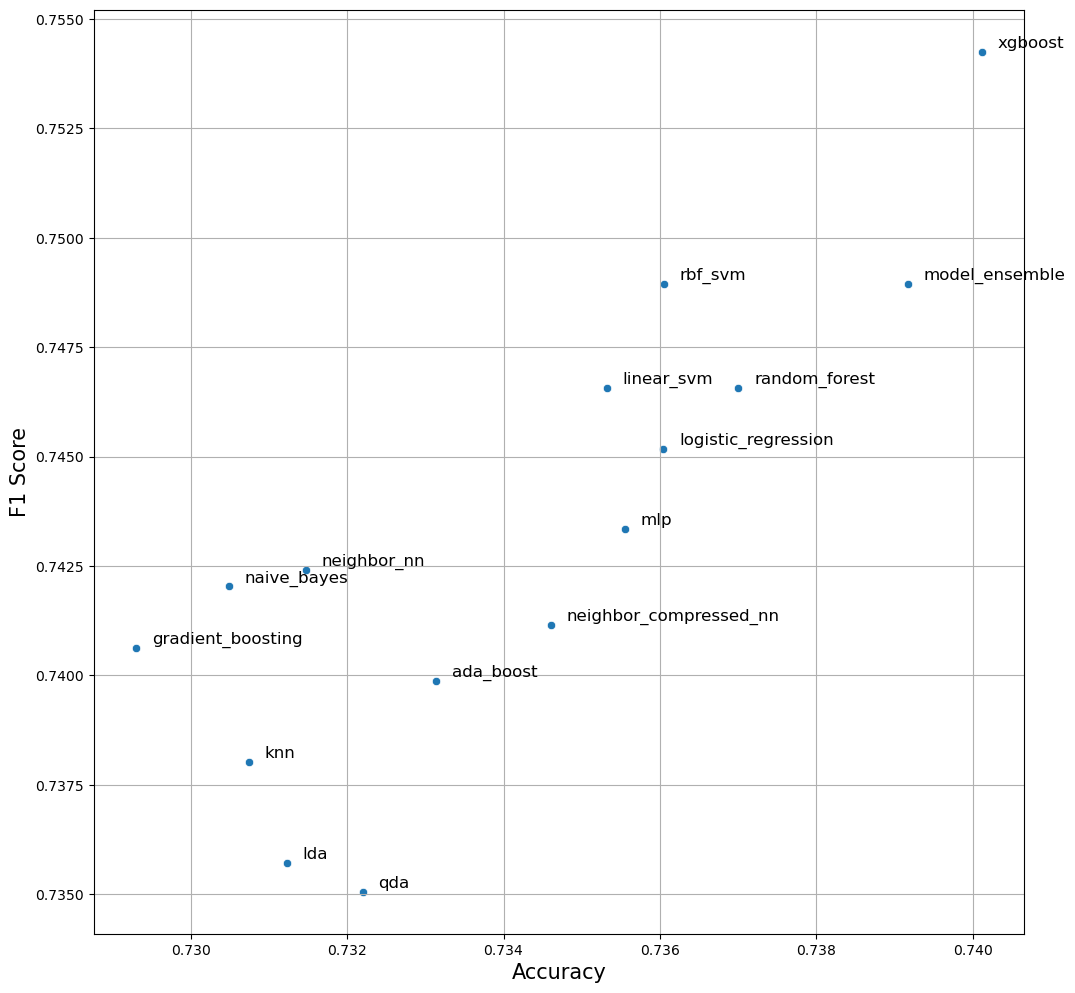

In [118]:
import seaborn as sns
plt.figure(figsize=(12,12))
lista_graph = list(zip(*new_models_df[(new_models_df["model"] != "poly_svm") & (new_models_df["model"] != "tree")].apply(lambda r: (r["model"], r["accuracy"], np.mean(r["complete_metrics"]["F1 Score"])), axis = 1).values))
sns.scatterplot(x = lista_graph[1], y = lista_graph[2])
plt.xlabel("Accuracy", fontdict={"size": 15})
plt.ylabel("F1 Score", fontdict={"size": 15})
# plt.axvline(x = np.max(accuracies[:3]))
for i in range(len(lista_graph[0])):
    plt.text(x = lista_graph[1][i] + 0.0002, y = lista_graph[2][i]+ 0.0001, s = lista_graph[0][i], fontdict={"size": 12})
plt.grid()

In [121]:
new_models_df["F1"] = new_models_df.apply(lambda r: np.round(np.mean(r["complete_metrics"]["F1 Score"]), 4), axis = 1)
new_models_df["F1_std"] = new_models_df.apply(lambda r: np.round(np.std(r["complete_metrics"]["F1 Score"])/ np.sqrt(10), 4), axis = 1)
new_models_df["Accuracy"] = new_models_df.apply(lambda r: np.round(np.mean(r["complete_metrics"]["Accuracy"]), 4), axis = 1)
new_models_df["Accuracy_std"] = new_models_df.apply(lambda r: np.round(np.std(r["complete_metrics"]["Accuracy"]) / np.sqrt(10), 4), axis = 1)
new_models_df["Precision"] = new_models_df.apply(lambda r: np.round(np.mean(r["complete_metrics"]["Precision"]), 4), axis = 1)
new_models_df["Precision_std"] = new_models_df.apply(lambda r: np.round(np.std(r["complete_metrics"]["Precision"]) / np.sqrt(10), 4), axis = 1)
new_models_df["Recall"] = new_models_df.apply(lambda r: np.round(np.mean(r["complete_metrics"]["Recall"]), 4), axis = 1)
new_models_df["Recall_std"] = new_models_df.apply(lambda r: np.round(np.std(r["complete_metrics"]["Recall"]) / np.sqrt(10), 4), axis = 1)
new_models_df["Specificity"] = new_models_df.apply(lambda r: np.round(np.mean(r["complete_metrics"]["Specificity"]), 4), axis = 1)
new_models_df["Specificity_std"] = new_models_df.apply(lambda r: np.round( np.std(r["complete_metrics"]["Specificity"]) / np.sqrt(10), 4), axis = 1)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [127]:
(new_models_df[["model", "Accuracy", "Accuracy_std","Precision", "Precision_std", "Recall", "Recall_std", "Specificity", "Specificity_std", "F1", "F1_std"]].set_index("model").T * 100)[["logistic_regression", "knn", "tree", "random_forest", "gradient_boosting", "ada_boost", "xgboost", "linear_svm", "rbf_svm", "lda", "qda", "naive_bayes", "mlp", "neighbor_nn", "neighbor_compressed_nn", "model_ensemble"]].T#.to_csv("performance_table.txt")#.to_latex("performance_table.txt", escape = False)

,Accuracy,Accuracy_std,Precision,Precision_std,Recall,Recall_std,Specificity,Specificity_std,F1,F1_std
model,,,,,,,,,,
logistic_regression,73.60,0.71,74.10,0.86,74.98,0.88,72.15,0.75,74.52,0.78
knn,73.07,0.83,73.98,1.08,73.66,0.82,72.48,0.94,73.80,0.90
tree,71.17,0.56,72.28,1.03,71.77,1.35,70.49,1.64,71.90,0.73
random_forest,73.36,0.84,73.16,1.01,76.25,0.94,70.27,0.95,74.66,0.92
gradient_boosting,72.86,0.76,72.82,0.93,75.39,1.07,70.11,0.86,74.06,0.91
ada_boost,73.31,0.83,74.27,1.00,73.75,0.99,72.75,1.13,73.99,0.91
xgboost,74.01,0.80,73.52,1.02,77.47,0.81,70.34,0.99,75.43,0.85
linear_svm,73.53,0.68,73.66,0.87,75.71,0.69,71.21,0.80,74.66,0.73
rbf_svm,73.60,0.75,73.42,0.96,76.46,0.79,70.58,0.90,74.89,0.79


In [ ]:
from sklearn.metrics import accuracy_score
import torch
from utils_parameter_search.models_params import models
target_y = config["DATA"]["target_y"]
sep_processed_data = config["DATA"]["sep_processed_data"]
# if sep_processed_data == "\\t":
#     sep_processed_data == "\t"

sep_processed_data = "\t"
data_dir: str = "data/split_data"

X, y, X_test, y_test = load(
        data_dir, target_y, sep_processed_data=sep_processed_data, return_df=True
    )

values = []
for _, row in new_models_df.iterrows():
    if row["model"] == "model_ensemble":
        # continue
        pass
    dataset = datasets[row["dataset"]]
    model = models[row["model"]]["model"]
    device = models[row["model"]].get("device", "cpu")


    pipeline = PipelineCV("RiskPerformance", **dataset)
    if row["params_initialization"] is not None:
        my_model = model(**row["params_initialization"])
    else:
        my_model = model()

    X_train, y_train = pipeline.fit_transform(X, y)
    X_t, y_t = pipeline.transform(X_test, y_test)

    if device == "cuda":
        my_model.to(device)
        if isinstance(X_train, torch.Tensor):
            X_train = X_train.to(device)
        else:
            X_train = torch.Tensor(X_train).to(device)
        if isinstance(y_train, torch.Tensor):
            y_train = y_train.to(device)
        else:
            y_train = torch.Tensor(y_train).to(device)

        if isinstance(X_t, torch.Tensor):
            X_t = X_t.to(device)
        else:
            X_t = torch.Tensor(X_t).to(device)
    if row["params_of_fit"] is not None:
        my_model.fit(X_train, y_train, **row["params_of_fit"])
    else:
        my_model.fit(X_train, y_train)


    if isinstance(y_t, torch.Tensor):
        y_t = y_t.cpu().numpy()

    preds = my_model.predict(X_t)
    values.append({row["model"]: accuracy_score(y_t, preds)})

In [120]:
values

[{'poly_svm': 0.7006737247353224},
 {'tree': 0.7074109720885466},
 {'gradient_boosting': 0.7305101058710298},
 {'naive_bayes': 0.7276227141482194},
 {'knn': 0.7353224254090471},
 {'lda': 0.7305101058710298},
 {'neighbor_nn': 0.7333974975938402},
 {'qda': 0.7343599615014437},
 {'ada_boost': 0.726660250240616},
 {'neighbor_compressed_nn': 0.726660250240616},
 {'linear_svm': 0.7362848893166506},
 {'mlp': 0.7410972088546679},
 {'logistic_regression': 0.7382098171318575},
 {'rbf_svm': 0.7343599615014437},
 {'random_forest': 0.7353224254090471},
 {'xgboost': 0.7343599615014437}]